## Интеллектуальный анализ данных – весна 2023
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV

import mlxtend
from mlxtend.plotting import plot_decision_regions
from itertools import product
from collections import Counter 

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

Пропущенные значения отсутствуют, все переменные - числовые.

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

На всякий случай выведу количество уникальных значений

In [4]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(110)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3)


Посмотрим на размерность обучающей и тестовой выборки:

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(124, 13) (124,)
(54, 13) (54,)


In [7]:
X.shape

(178, 13)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

<b>Евклидово расстояние</b> является геометрическим расстоянием в многомерном пространстве. Евклидово расстояние между точками x и y в n-мерном пространстве вычисляется по следующей формуле:

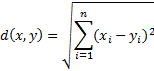

In [16]:
n_neigbours = [1, 3, 5, 10, 15, 25]

scaler = StandardScaler()

X_train = pd.DataFrame(data=scaler.fit_transform(X_train),
                       columns=X_train.columns)

X_test = pd.DataFrame(data=scaler.transform(X_test),
                      columns=X_test.columns)

In [17]:
def train_knn(n):
    knn = KNeighborsClassifier(n_neighbors=n, metric='euclidean')
    knn.fit(temp_train, y_train)
    train_res = accuracy_score(y_train, knn.predict(temp_train))
    test_res = accuracy_score(y_test, knn.predict(temp_test))
    print(f'{n} neighbours: \n\ttrain result: {train_res} \n\ttest result: {test_res}')
    return knn  

In [18]:
temp_test = X_test[['alcohol', 'magnesium']]
temp_train = X_train[['alcohol', 'magnesium']]

classifiers_list = [train_knn(n) for n in n_neigbours] # сохраним для следующего задания

1 neighbours: 
	train result: 1.0 
	test result: 0.7222222222222222
3 neighbours: 
	train result: 0.8145161290322581 
	test result: 0.7222222222222222
5 neighbours: 
	train result: 0.7741935483870968 
	test result: 0.7407407407407407
10 neighbours: 
	train result: 0.7661290322580645 
	test result: 0.7962962962962963
15 neighbours: 
	train result: 0.7419354838709677 
	test result: 0.7777777777777778
25 neighbours: 
	train result: 0.7016129032258065 
	test result: 0.7222222222222222


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [11]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

`gridspec.GridSpec()` - Макет сетки для размещения подграфиков в более крупном.
`itertools.product()` - Декартово произведение, эквивалентное вложенному циклу for
`plot_decision_region()` - Функция для построения областей принятия решений классификаторов в 1 или 2 измерениях.

In [12]:
def visualize_knn(heading, X, y):
    n_neigbours_1 = list(map(str, n_neigbours))
    gs = gridspec.GridSpec(2, 3)
    fig = plt.figure(figsize=(16, 8))
    res = list(product([0, 1], [0, 1, 2]))
    fig.suptitle(heading)

    for clf, lab, grd in zip(classifiers_list,
                             n_neigbours_1,
                             res):

        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(y=y,
                                    X=X.to_numpy(),
                                    clf=clf,
                                    legend=2)
        plt.title(f'number of neighbours = {lab}')
    
    plt.show()

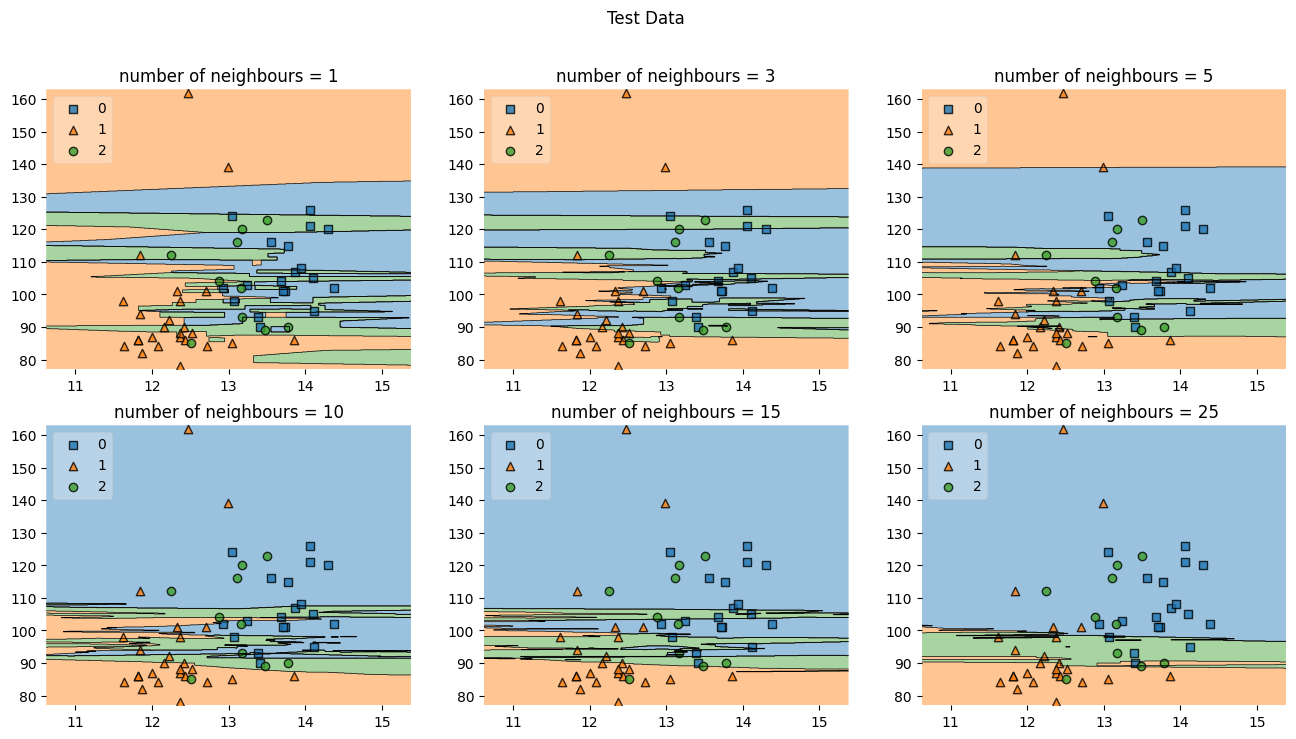

CPU times: total: 3min 42s
Wall time: 3min 42s


In [13]:
%%time
visualize_knn('Test Data', temp_test, y_test)

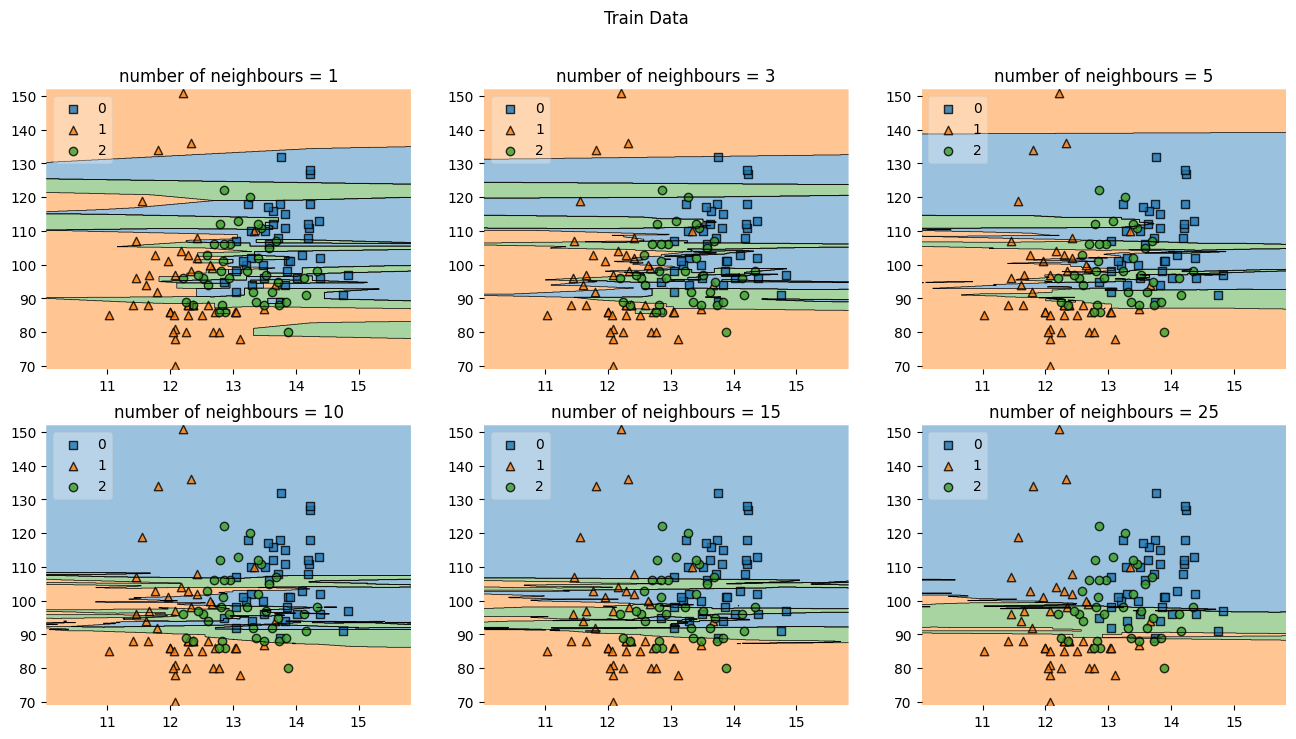

CPU times: total: 3min 58s
Wall time: 3min 58s


In [14]:
%%time
visualize_knn('Train Data', temp_train, y_train)

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

Общий паттерн заключается в том, что если мы выбираем небольшое число соседей, то происходит переобучение с запоминанием выборки. Если же количество соседей приближается к количеству объектов, то модель начинает выдавать 1 класс, преобладающий в выборке. Следовательно, в подавляющем большинстве случаев оптимальным количеством соседей будет число несколько отдалённое от 1, но и не приближающееся к количеству элементов в выборке.

Это и наблюдаем на крайних значениях. Самый лучший вариант на тестовой выборке - 10 соседей. Зоны здесь сепарируются более плавно, чем на других вариантах, не "рваных зон" как на небольшом числе соседей и доминации одной из зон как на 25 соседях. Это также подтверждает предыдущий отчёт.

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

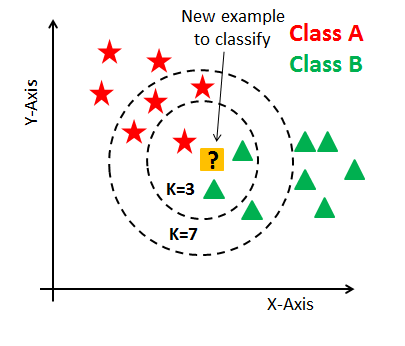

In [61]:
# https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/#what-is-knn
# чем вдохновлялся
class KNN:
    def __init__(self, k:int):
        self.k = k
    
    def fit(self, X, y):
        # YOUR CODE HERE
        self.y_train = y
        self.X_train = X
    
    def predict(self, X):
        # YOUR CODE HERE
        neighs = list()
        
        for obj in X:
            
            # euclidean metric
            distances = np.sqrt(np.sum(np.square(self.X_train - obj), axis=1))
            distances = list(zip(distances, self.y_train))
            distances.sort()
            y_sorted = [y for dist, y in distances]
            neighs.append(y_sorted[:self.k])
        
        # the most common value
        most_common = np.array(list(map(lambda x: 
                      max(frozenset(x), key=x.count), neighs)))
        return most_common

In [62]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [60]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [22]:
data = pd.read_csv(r'C:\Users\79603\Desktop\Ucheba\ИАД\Введение в машинное обучение\diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [24]:
data.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [25]:
data.tail(20)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
53920,53921,0.70,Very Good,E,VS2,62.4,60.0,2755,5.57,5.61,3.49
53921,53922,0.70,Very Good,E,VS2,62.8,60.0,2755,5.59,5.65,3.53
53922,53923,0.70,Very Good,D,VS1,63.1,59.0,2755,5.67,5.58,3.55
53923,53924,0.73,Ideal,I,VS2,61.3,56.0,2756,5.80,5.84,3.57
53924,53925,0.73,Ideal,I,VS2,61.6,55.0,2756,5.82,5.84,3.59
53925,53926,0.79,Ideal,I,SI1,61.6,56.0,2756,5.95,5.97,3.67
53926,53927,0.71,Ideal,E,SI1,61.9,56.0,2756,5.71,5.73,3.54
53927,53928,0.79,Good,F,SI1,58.1,59.0,2756,6.06,6.13,3.54
53928,53929,0.79,Premium,E,SI2,61.4,58.0,2756,6.03,5.96,3.68
53929,53930,0.71,Ideal,G,VS1,61.4,56.0,2756,5.76,5.73,3.53


In [26]:
data.nunique()

Unnamed: 0    53940
carat           273
cut               5
color             7
clarity           8
depth           184
table           127
price         11602
x               554
y               552
z               375
dtype: int64

In [27]:
data.drop(['Unnamed: 0'], axis=1, inplace=True) # дублирует индекс + 1, остальное нужное, 
                                                # судя по описанию датасета

**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [28]:
data.corr('pearson').style.background_gradient(cmap='coolwarm') # вывожу корреляции Пирсона

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


Здесь видим, что carat, x, y, z (от большей к меньшей) имеют приближающуюсяя к 1 корреляцию Пирсона.

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [29]:
data = pd.get_dummies(data, drop_first=True)
data

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0,1,0,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,1,0,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0,0,1,...,1,0,0,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [30]:
X = data.drop(['price'], axis=1)
y = data.price
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [31]:
scaler = StandardScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train),
                       columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test),
                      columns=X_test.columns)

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [32]:
model = LinearRegression().fit(X_train, y_train)
train_result = mean_squared_error(y_train, model.predict(X_train))
test_result = mean_squared_error(y_test, model.predict(X_test))
print (f'''train result: {train_result}
test result: {test_result}''')

train result: 1281890.4627937279
test result: 1265203.917959545


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [33]:
X_train

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.508565,-0.033870,-1.104693,0.675367,0.708759,0.677236,-0.316605,1.231679,-0.587443,-0.540594,...,2.343045,-0.334127,-0.236311,-0.186183,-0.565014,2.201934,-0.419530,-0.544192,-0.270929,-0.320690
1,-0.837731,0.317681,0.692602,-0.917858,-0.965406,-0.884348,-0.316605,-0.811900,1.702293,-0.540594,...,-0.426795,-0.334127,-0.236311,-0.186183,-0.565014,-0.454146,-0.419530,-0.544192,-0.270929,3.118278
2,-0.816695,-1.229146,1.591250,-0.802149,-0.858544,-0.926553,-0.316605,-0.811900,1.702293,-0.540594,...,2.343045,-0.334127,-0.236311,-0.186183,1.769867,-0.454146,-0.419530,-0.544192,-0.270929,-0.320690
3,0.045776,0.458302,-0.655369,0.283736,0.236787,0.311460,-0.316605,1.231679,-0.587443,-0.540594,...,2.343045,-0.334127,-0.236311,-0.186183,1.769867,-0.454146,-0.419530,-0.544192,-0.270929,-0.320690
4,-0.627372,0.106750,0.243278,-0.597433,-0.573580,-0.560777,-0.316605,1.231679,-0.587443,-0.540594,...,-0.426795,-0.334127,-0.236311,-0.186183,-0.565014,-0.454146,-0.419530,-0.544192,-0.270929,3.118278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37753,-0.942910,-0.736974,-0.655369,-1.006865,-1.045552,-1.067236,-0.316605,1.231679,-0.587443,-0.540594,...,-0.426795,-0.334127,-0.236311,-0.186183,-0.565014,-0.454146,-0.419530,1.837587,-0.270929,-0.320690
37754,1.707609,0.317681,0.243278,1.538735,1.617082,1.591677,-0.316605,-0.811900,1.702293,-0.540594,...,-0.426795,2.992871,-0.236311,-0.186183,-0.565014,-0.454146,2.383621,-0.544192,-0.270929,-0.320690
37755,-0.585301,-0.033870,-1.104693,-0.517326,-0.502339,-0.490435,-0.316605,-0.811900,-0.587443,1.849819,...,2.343045,-0.334127,-0.236311,-0.186183,-0.565014,-0.454146,2.383621,-0.544192,-0.270929,-0.320690
37756,0.424421,-1.651008,1.141926,0.737672,0.664233,0.466211,-0.316605,-0.811900,1.702293,-0.540594,...,-0.426795,-0.334127,-0.236311,-0.186183,-0.565014,2.201934,-0.419530,-0.544192,-0.270929,-0.320690


carat, depth, table, x, y - вещественные переменные. Большие коэффициенты наблюдаются у (предлог) x (икс) и carat (по модулю). Это подтверждается матрицей с корреляциями выше.	

In [34]:
model.coef_[:6]

array([ 5345.48454554,   -93.57212322,   -64.87402856, -1186.47749402,
          56.17926457,   -26.15432424])

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [35]:
lr_ridge = Ridge(10).fit(X_train, y_train)
ridge_train = mean_squared_error(y_train, lr_ridge.predict(X_train))
ridge_test = mean_squared_error(y_test, lr_ridge.predict(X_test))

print (f'''ridge train: {ridge_train}
ridge test: {ridge_test}''')

ridge train: 1282023.9679948236
ridge test: 1264851.2193205848


In [36]:
lr_lasso = Lasso(10).fit(X_train, y_train)
lasso_train = mean_squared_error(y_train, lr_lasso.predict(X_train))
lasso_test = mean_squared_error(y_test, lr_lasso.predict(X_test))

print (f'''lasso train: {lasso_train}
lasso test: {lasso_test}''')

lasso train: 1342017.6852261985
lasso test: 1320282.6857134905


In [37]:
print(f'''Standart LR: 
\t{model.coef_[:6]}
Ridge LR: 
\t{lr_ridge.coef_[:6]}
Lasso LR: 
\t{lr_lasso.coef_[:6]}
''')

Standart LR: 
	[ 5345.48454554   -93.57212322   -64.87402856 -1186.47749402
    56.17926457   -26.15432424]
Ridge LR: 
	[ 5305.70937019   -91.62319298   -65.09535649 -1132.35917924
    43.76343905   -30.19564998]
Lasso LR: 
	[4838.45430392  -97.72456434  -77.12824141 -666.44119668   -0.
  -27.92939696]



**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

Лассо более агрессивно уменьшает веса, чем Ридж. Уже понятно из самого вида формул, что в Ридж штрафы будут меньше.

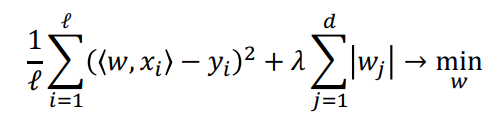 Лассо.

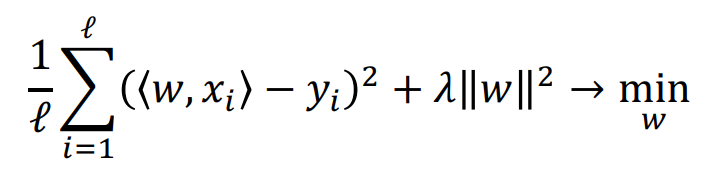 Ридж.

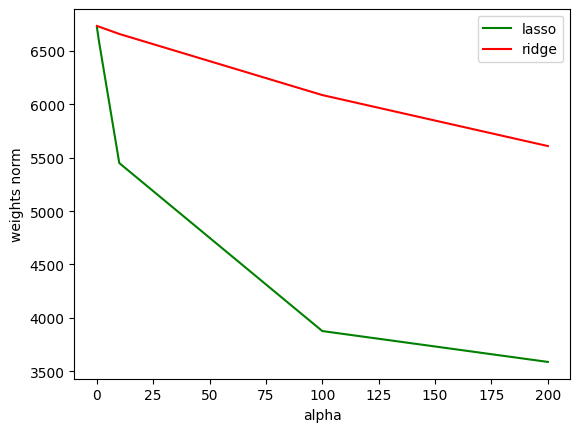

In [38]:
alpha = (0.1, 1, 10, 100, 200)
lasso, ridge = [], []

for i in alpha:
    lr_lasso = Lasso(i).fit(X_train, y_train)
    lasso.append(np.linalg.norm(lr_lasso.coef_))
    
    lr_ridge = Ridge(i).fit(X_train, y_train)
    ridge.append(np.linalg.norm(lr_ridge.coef_))
    
plt.ylabel('weights norm')
plt.xlabel('alpha')

plt.plot(alpha, lasso, label='lasso', color='green')
plt.plot(alpha, ridge, label='ridge', color='red')

plt.legend()
plt.show()

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [47]:
models = LassoCV(cv=5, alphas=alpha).fit(X_train, y_train)
parameters = models.alphas_
mse_ = models.mse_path_.mean(axis=1)

In [48]:
best_par, mn = 0, float("inf")

for parameter, error in zip(parameters, mse_):
    if mn > error:
        mn, best_par = error, parameter
    print(f'{parameter} {error}')
print(f"При значении параметра {best_par} получаем минимальную ошибку {mn}")

200.0 2166830.1537243635
100.0 1797353.866956845
10.0 1346636.739248065
1.0 1288690.0892199252
0.1 1304159.381734809
При значении параметра 1.0 получаем минимальную ошибку 1288690.0892199252


И следовательно, максимальное качество работы. Для наглядности.

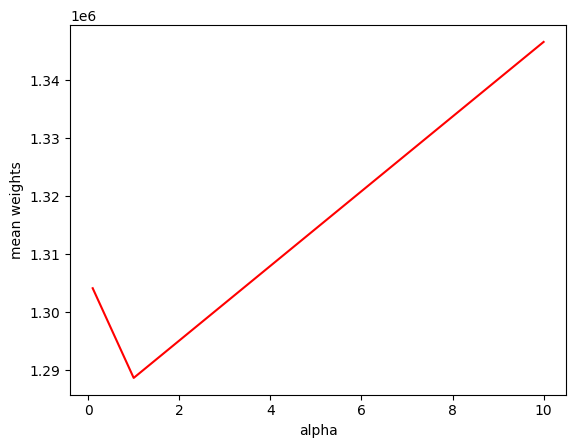

In [56]:
plt.plot(parameters[2:], mse_[2:], color='red')
plt.ylabel('mean weights')
plt.xlabel('alpha')
plt.show()

Покрупнее

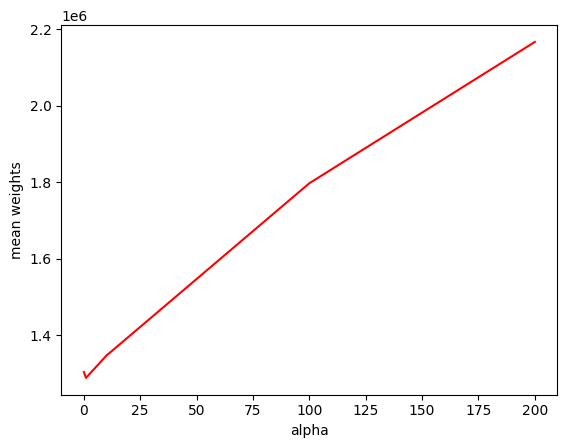

In [57]:
plt.plot(parameters, mse_, color='red')
plt.ylabel('mean weights')
plt.xlabel('alpha')
plt.show()

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [43]:
best_lr_lasso = Lasso(best_par).fit(X_train, y_train)
lasso_train = mean_squared_error(y_train, best_lr_lasso.predict(X_train))
lasso_best_coef = best_lr_lasso.coef_

print (f'''lasso train result: {lasso_train}

lasso coef: {lasso_best_coef}''')

lasso train result: 1282555.8606755133

lasso coef: [ 5296.15506643   -94.59499535   -66.27115952 -1087.91558376
     0.           -23.86633476   141.97022431   359.38722607
   291.37831034   266.71984152   -75.80761966  -101.65921005
  -191.23211767  -346.38874775  -437.30898809  -528.65780548
   936.83931225  1524.74132204   980.24621403  1592.88232625
  1745.55589437  1236.4724119   1404.80664797]


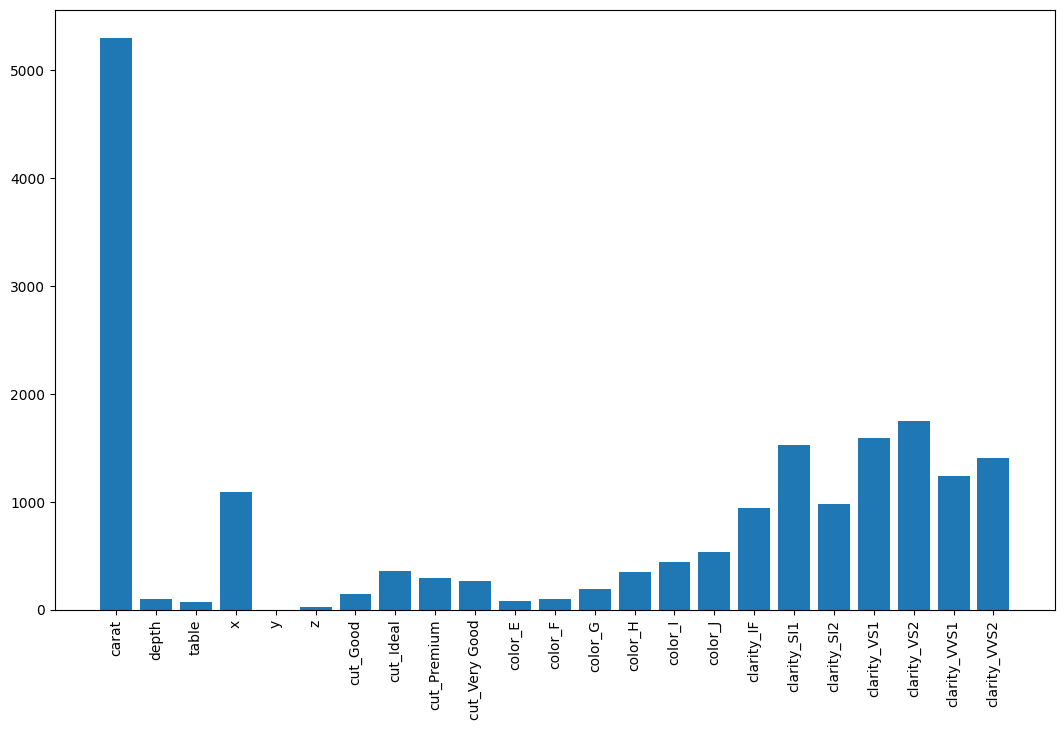

In [44]:
numbers = np.abs(lasso_best_coef)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes((0,0,1,1))
plt.xticks(rotation=90)

ax.bar(X_train.columns, numbers)
plt.show()

Исходя из графика: такие признаки как z, depth, color_e, table обладают низкой информативностью. y обладает нулевой информативностью.

Carat имеет наибольшую информативность, также достаточно высокий коэффициент у x и признаков, восходящих к clatity. carat и clarity - вес и параметры блеска соответственно. 

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [45]:
lin_reg = LinearRegression().fit(X_train, y_train)
print(f'''Test standart:\n\t{mean_squared_error(y_test, lin_reg.predict(X_test))}
Test lasso:\n\t{mean_squared_error(y_test, best_lr_lasso.predict(X_test))}''')

Test standart:
	1265203.917959545
Test lasso:
	1264806.436037907


In [46]:
print(f'''Standart: {lin_reg.coef_}

Lasso: {best_lr_lasso.coef_}
''')

Standart: [ 5345.48454554   -93.57212322   -64.87402856 -1186.47749402
    56.17926457   -26.15432424   153.55823608   378.62802698
   309.53969792   282.18437178   -82.90812202  -108.30748207
  -198.92629758  -353.50402534  -444.37865383  -534.70747732
   968.14804635  1597.61981255  1043.60119662  1654.24492415
  1817.00740924  1279.81091175  1454.57049311]

Lasso: [ 5296.15506643   -94.59499535   -66.27115952 -1087.91558376
     0.           -23.86633476   141.97022431   359.38722607
   291.37831034   266.71984152   -75.80761966  -101.65921005
  -191.23211767  -346.38874775  -437.30898809  -528.65780548
   936.83931225  1524.74132204   980.24621403  1592.88232625
  1745.55589437  1236.4724119   1404.80664797]



Регрессия занулила 1 признак. У Лассо результаты немного лучше. Кажется, здесь наблюдаем отсутствие мультиколлинеарности (при лучшем коэффициенте регуляризации результат почти совпадает с изначальным, а вот относительно других коэффициентов - ошибка выше)